In [1]:
import os
import numpy as np
import torch
import util
import matplotlib.pyplot as plt
from data import fr
from torch.autograd.gradcheck import zero_gradients
%matplotlib inline

In [34]:
def compute_jacobian_and_bias(inputs, net):
    inputs.requires_grad = True
    outputs = net(inputs)
    
    inp_n1 = inputs.shape[-2]
    inp_n2 = inputs.shape[-1]
    out_n = outputs.shape[-1]
    
    jacobian = torch.zeros([inp_n1, inp_n2, out_n])
    
    for i in range(out_n):
        zero_gradients(inputs)
        outputs[0, i].backward(retain_graph = True)
        jacobian[:, :, i] = inputs.grad.data[0, 0]
        
    return jacobian.numpy(), inputs.detach().numpy(), outputs.detach().numpy()

def compute_bias(jacobian, inputs, outputs):
    grad = jacobian[0] + 1j * jacobian[1]
    jacobian_conj =  jacobian[0]  - 1j * jacobian[1]
    inputs_signal = inputs[0, 0] + inputs[0, 1] * 1j
    pred = jacobian_conj.T * inputs_signal
    print(pred.shape)
    pred = pred.sum(axis=1)
    # pred = np.abs(pred)
    return grad, pred

def check_bias(fr_module):
    for layer in fr_module.modules():
        if str(layer).startswith('BFBatchNorm1d'):
            x = torch.randn((8,64, 100))
            alpha = 10
            input1 = alpha * layer(x)
            input2 = layer(x * alpha)
            check = (input1 - input2).sum()
            x = torch.zeros((8,64, 100))
            input1 = layer(x)
            print(check.item(), input1.sum().item())

In [3]:
fr_path = 'checkpoint/model_snr_30_bias_yes/fr/epoch_300.pth'
fc_path = 'checkpoint/model_snr_30_bias_yes/fc/epoch_300.pth'
data_dir = 'test_dataset'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#load models
fr_module, _, _, _, _ = util.load(fr_path, 'fr', device)
fc_module, _, _, _, _ = util.load(fc_path, 'fc', device)
fr_module.cpu()
fr_module.eval()
fc_module.cpu()
fc_module.eval()
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)

In [4]:
check_bias(fr_module)

75256.1875 8361.76953125
24429.48046875 2714.377685546875
61959.21484375 6884.38623046875
62425.59375 6936.09716796875
23747.93359375 2638.680419921875
64417.25390625 7157.50341796875
45899.5 5099.92919921875
-62148.31640625 -6905.34033203125
10719.306640625 1191.0274658203125
18152.126953125 2016.900146484375
45541.59765625 5060.17138671875
-30799.224609375 -3422.087646484375
-31853.279296875 -3539.238037109375
-23200.19921875 -2577.795654296875
-18103.4453125 -2011.500732421875
-51037.15625 -5670.79638671875
-39009.109375 -4334.357421875
26677.283203125 2964.142578125
-2358.734375 -262.0847473144531
9302.298828125 1033.5919189453125


In [5]:
#load data
f = np.load(os.path.join(data_dir, 'f.npy'))
signal_0dB = np.load(os.path.join(data_dir, '0.0dB.npy'))
signal_10dB = np.load(os.path.join(data_dir, '10.0dB.npy'))
signal_50dB = np.load(os.path.join(data_dir, '50.0dB.npy'))
nfreq = nfreq = np.sum(f >= -0.5, axis=1)

### Frequency estimation

In [6]:
idx = 8
inp = torch.as_tensor(signal_10dB[idx][None])

## Compute Jacobian

In [7]:
jacobian, inputs, outputs = compute_jacobian_and_bias(inp, fr_module)
grad, bias = compute_bias(jacobian, inputs, outputs)

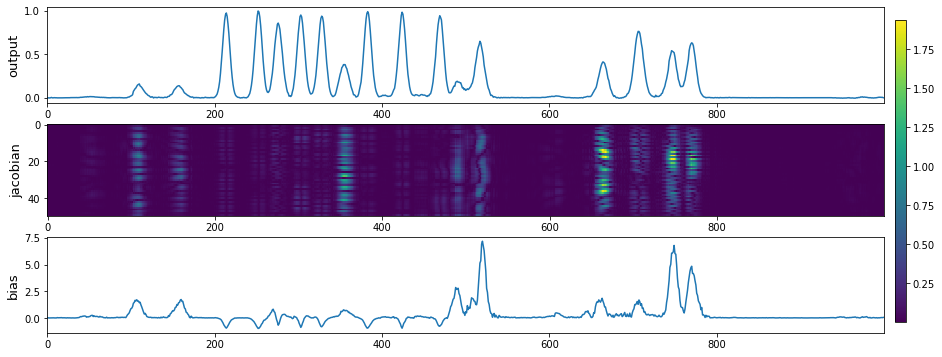

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(15, 6))

ax[0].plot(xgrid, outputs[0])
ax[0].set_xticks(np.arange(-0.5, 0.5, 0.2))
ax[0].set_xticklabels(np.arange(0, 1000, 200))
ax[0].set_xlim(-0.5, 0.5)
ax[0].set_ylabel('output', fontsize=13)

im = ax[1].imshow(np.abs(grad))
ax[1].set_aspect(2.2)
ax[1].set_ylabel('jacobian', fontsize=13)

ax[2].plot(xgrid, bias[0])
ax[2].set_xticks(np.arange(-0.5, 0.5, 0.2))
ax[2].set_xticklabels(np.arange(0, 1000, 200))
ax[2].set_xlim(-0.5, 0.5)
ax[2].set_ylabel('bias', fontsize=13)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

## Bias Free Model

In [9]:
fr_path = 'checkpoint/model_snr_30_bias_no/fr/epoch_300.pth'
fc_path = 'checkpoint/model_snr_30_bias_no/fc/epoch_300.pth'
data_dir = 'test_dataset'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#load models
fr_module, _, _, _, _ = util.load(fr_path, 'fr', device)
fr_module.cpu()
fr_module.eval()
xgrid = np.linspace(-0.5, 0.5, fr_module.fr_size, endpoint=False)

In [10]:
check_bias(fr_module)

-0.00034914398565888405 0.0
-3.8854152080602944e-05 0.0
7.817649748176336e-05 0.0
1.138483639806509e-06 0.0
0.00010458947508595884 0.0
-0.0002595217665657401 0.0
4.661983984988183e-05 0.0
-0.0002687150554265827 0.0
0.0001395900035277009 0.0
-7.241056300699711e-05 0.0
-2.9325485229492188e-05 0.0
-4.5190099626779556e-05 0.0
-0.00024958112044259906 0.0
-1.1653348337858915e-05 0.0
1.5225043171085417e-05 0.0
-0.00019079374033026397 0.0
0.0001969951845239848 0.0
-0.00010391641990281641 0.0
4.010795964859426e-05 0.0
0.00014300335897132754 0.0


In [15]:
jacobian, inputs, outputs = compute_jacobian_and_bias(inp, fr_module)
grad, pred = compute_bias(jacobian, inputs, outputs)

In [32]:
alpha = 1.5
outputs1 = fr_module(alpha * inp)
outputs2 = alpha * fr_module(inp)
(outputs1 - outputs2).abs().max()

tensor(4.4703e-06, grad_fn=<MaxBackward1>)

In [33]:
zero_inputs = torch.zeros(inp.shape)
outputs3 = fr_module(zero_inputs)
print(outputs3.abs().max())

tensor(0., grad_fn=<MaxBackward1>)


In [19]:
bias = pred.real - outputs

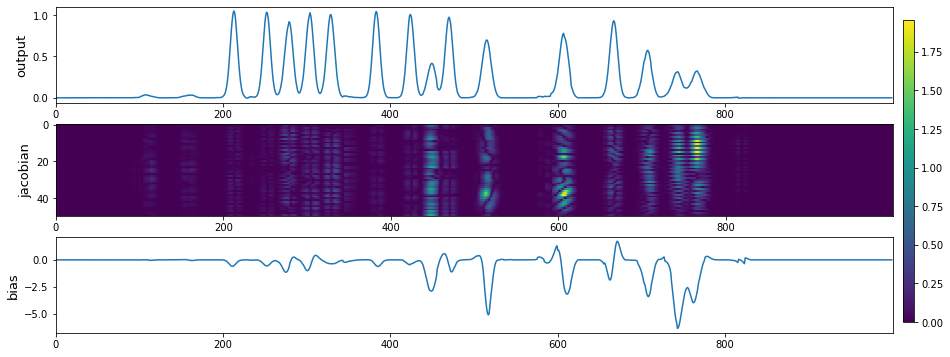

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(15, 6))

ax[0].plot(xgrid, outputs[0])
ax[0].set_xticks(np.arange(-0.5, 0.5, 0.2))
ax[0].set_xticklabels(np.arange(0, 1000, 200))
ax[0].set_xlim(-0.5, 0.5)
ax[0].set_ylabel('output', fontsize=13)

im = ax[1].imshow(np.abs(grad))
ax[1].set_aspect(2.2)
ax[1].set_ylabel('jacobian', fontsize=13)

ax[2].plot(xgrid, bias[0])
ax[2].set_xticks(np.arange(-0.5, 0.5, 0.2))
ax[2].set_xticklabels(np.arange(0, 1000, 200))
ax[2].set_xlim(-0.5, 0.5)
ax[2].set_ylabel('bias', fontsize=13)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()